In [23]:
# Always run this block first whenever you change the bvd_library.py file, otherwise the change won't be updated to this notebook.
import importlib
import bvd_library
importlib.reload(bvd_library)
from bvd_library import *

# add %matplotlib widget to make plots interactive
%matplotlib widget
mpl.style.use('seaborn')
mpl.style.use('seaborn-muted')

First, we create a BVD_Model instance and load file. Then we plot |S11| and identify resonance.

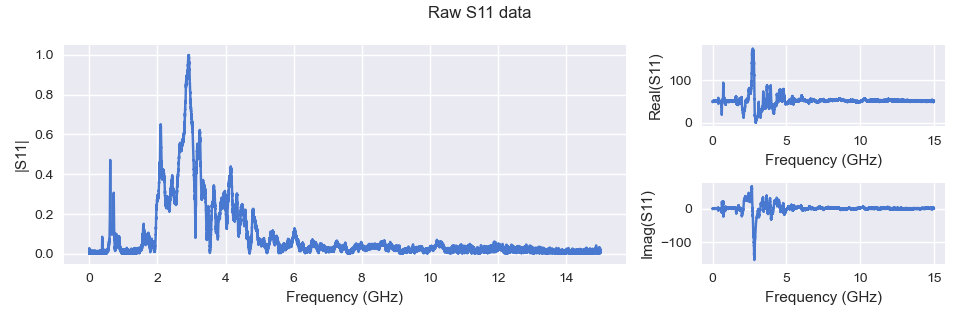

In [34]:
bvd_model = BVD_Model()
# bvd_model.load_file('Rings_240508/Ring_30_4K.s2p', normalize=False, s_matrix='11')
bvd_model.load_file('20240506_ACOV2_T/Ring_30_4K.s2p', normalize=True, s_matrix='12')
bvd_model.plot_s11(figscale=0.8)

From the |S11| plot, we can identify the background frequency range with <span style="color:green">[fbs, fbe]</span>, and the resonance region with <span style="color:green">[frs, fre]</span>. We first do background fitting to obtain Rs, Ls, Rp, Cp; then we do resonance fitting to obtain Rm, Cm, Lm. Procedure for fitting S11 with BVD model is:

From S11 data, we compute raw impedance using $Z_0 = Z_{char} \times \dfrac{1+S11}{1-S11}$, where characteristic impedance $Z_{char}$ is taken to be 50 ohm. Raw admittance is $Y_0 = \dfrac{1}{Z_0}$.

We slice two flat regions out of raw impedance and concatenate them to obtain background impledance data $Z_{bg}$, which can be fitted using equation: $$Z_{bg,fit}= R_s + jwL_s + \dfrac{1}{\dfrac{1}{R_p} + jwC_p}$$

We fit $Z_{bg}$ data with $Z_{bg,fit}$ equation using <span style="color:blue">bvd_model.fit_BVD_model_background</span> method and obtain <span style="color:red">[Rs, Ls, Rp, Cp]</span>; 

Ls = -2.080579979720502 nH; Rs = 5.627717380786414 Ohm; Rp = 20956319.909153525 Ohm; Cp = 0.00037992062316875055 nF


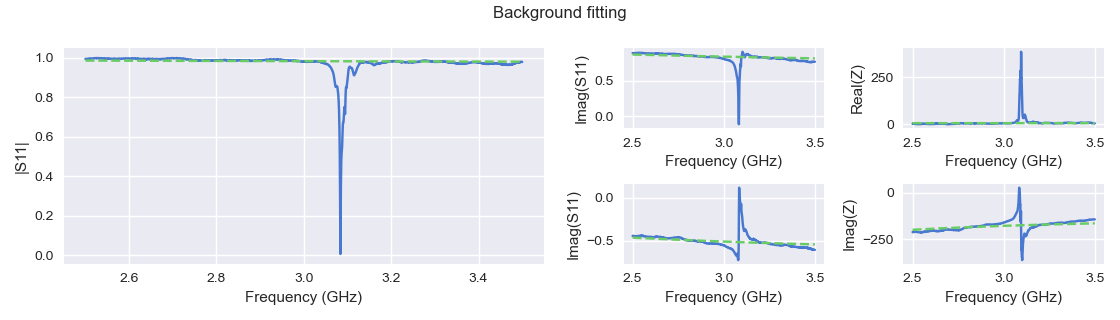

In [16]:
fbs, frs, fre, fbe = 2.7e9, 3.04e9, 3.13e9, 3.27e9
_, _, BG_fit_params = bvd_model.fit_BVD_model_background(start1=fbs, end1=frs, start2=fre, end2=fbe,
                                                          plot_fit=True, figscale=0.8)
[Ls, Rs, Rp, Cp] = BG_fit_params
print('Ls =', Ls, 'nH;', 'Rs =', Rs, 'Ohm;', 'Rp =', Rp, 'Ohm;', 'Cp =', Cp, 'nF')

Using the fitted [Ls, Rs, Rp, Cp], we de-background raw admittance data $Y_0$ to obtain: $$Y_a = \dfrac{1}{Z_0 - R_s - jwL_s} - (\dfrac{1}{R_p} + jwC_p) $$

The admittance data here can be modeled with the RLC circuit, which can be fitted with equation: $$Y_{a,fit}=\frac{1}{R_m + jwL_m + \dfrac{1}{jwC_m}}$$

We fit $Y_a$ data with $Y_{a,fit}$ using <span style="color:blue">bvd_model.fit_BVD_model_resonances</span> method, and obtain <span style="color:red">[Rm, Lm, Cm]</span>.

Lm = 1708.2830238046704 nH; Cm = 1.5610440901182124e-06 nF; Rm = 20.39042960874476 Ohm


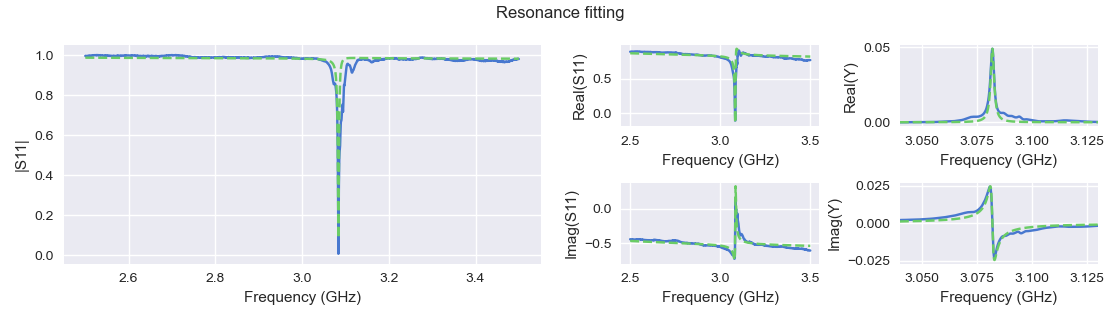

In [17]:
s11_fit, Z_total, popt, Y_list = bvd_model.fit_BVD_model_resonances(start1=fbs, end1=frs, start2=fre, end2=fbe,
                                                            bg_params=BG_fit_params, RS_fit_params_manual=None,
                                                            plot_fit=True, figscale=0.8)
[Lm, Cm, Rm] = popt
print('Lm =', Lm, 'nH;', 'Cm =', Cm, 'nF;', 'Rm =', Rm, 'Ohm')

In [18]:
k2 = Cm / (Cp + Cm)
print(k2)

0.0040920553308238196


**More details about fitting:**

When fitting complex numbers, we need to seperate real & and imaginary parts and stack them so that the optimizer will optimize the least square of $|Re(F_{fit}) - Re(F_{data})| + |Im(F_{fit}) - Im(F_{data})|$. 

Thus, for <span style="color:blue">bvd_model.fit_BVD_model_background</span> method, we can write: $$Re(Z_{bg,fit}) = Rs + \dfrac{R_p}{1 + (wC_pR_p)^2}$$ $$Im(Z_{bg,fit}) = wL_s - \dfrac{wR_p^2C_p}{1 + (wR_pC_p)^2}$$ which is implemented in <span style="color:purple">Z_background</span> function.

For <span style="color:blue">bvd_model.fit_BVD_model_resonances</span> method: we can write: $$Re(Y_{a,fit}) = \dfrac{R_m}{R_m^2 + (wL_m - \dfrac{1}{wC_m})}$$ $$Im(Y_{a,fit}) = -\dfrac{wL_m - \dfrac{1}{wC_m}}{R_m^2 + (wL_m - \dfrac{1}{wC_m})}$$ which is implemented in <span style="color:purple">Y_resonance</span> function.

When fitting the resonance, a key step is to find good initial guesses. For RLC circuit, at resonance frequencies $w_r$ (peak of real admittance) and $w_l$ (dip of imaginary admittance), we can compute:
$$R_{m0} = \dfrac{1}{Y_{a}[w_r]}$$
$$L_{m0} = \dfrac{R_{m0} * w_l}{w_l^2 - w_r^2} $$
$$C_{m0} = \dfrac{1}{L_{m0} * w_r^2}$$

These initial guesses [Lm0, Cm0, Rm0] will be fed into the <span style="color:orange">curve_fit</span> optimizer to assist convergence.

**Loading .prn file:**

We can also load .prn file. However, this will likely prompt you to install a 'matlabengin' libray, which can be done with "python pip install matlabengine" cammand. It also requires Matlab is already installed on the computer.

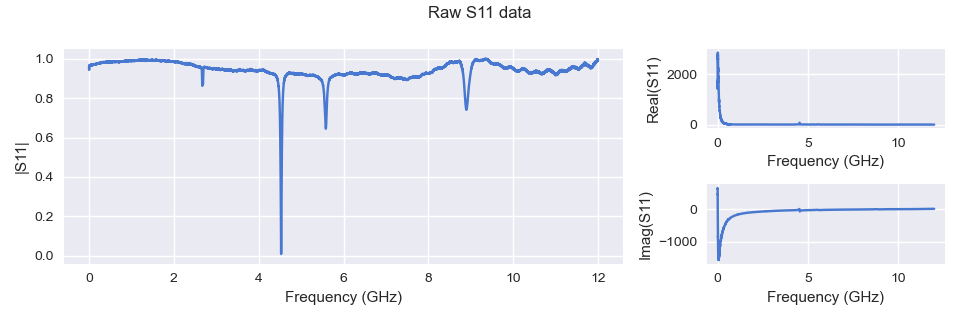

In [8]:
bvd_model.load_file('3-S22-pol-span500M-4k-1prn.prn')
bvd_model.plot_s11(figscale=0.8)

From the |S11| plot, we set <span style="color:green">[fbs, frs, fre, fbe]</span> as before.

Ls = 0.2609268708011194 nH; Rs = 2.164788916496168 Ohm; Rp = 6893.990305717491 Ohm; Cp = 0.00082667040865783 nF
Lm = 145.48679520207793 nH; Cm = 8.535864579693588e-06 nF; Rm = 24.32589033819095 Ohm


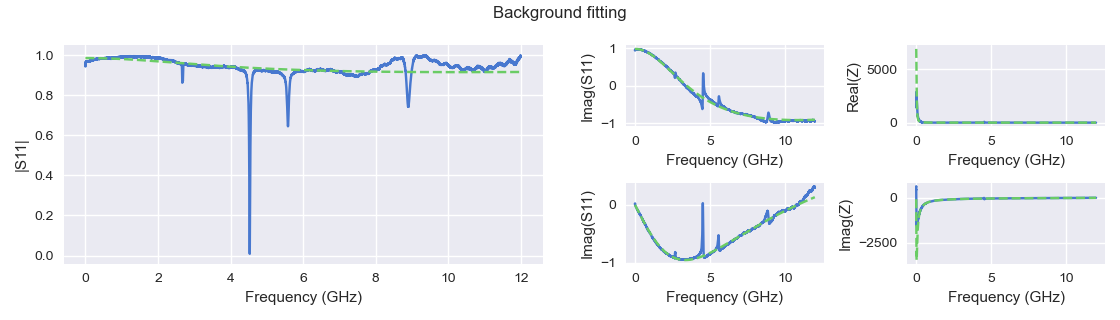

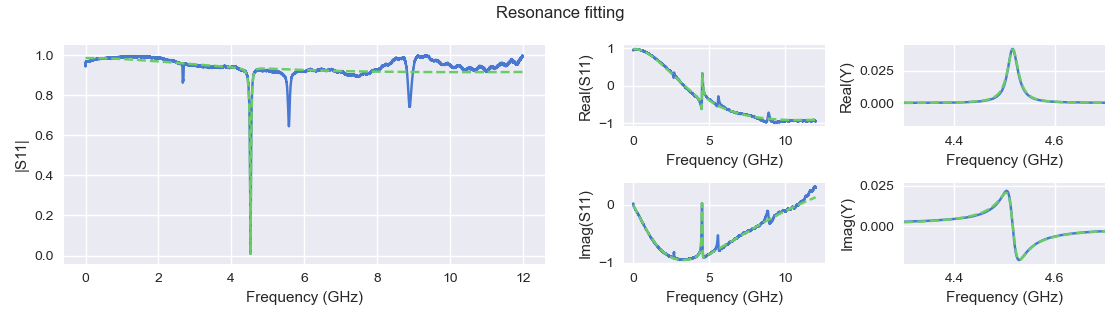

In [9]:
fbs, frs, fre, fbe = 2e9, 4.3e9, 4.7e9, 10e9
_, _, BG_fit_params = bvd_model.fit_BVD_model_background(start1=fbs, end1=frs, start2=fre, end2=fbe,
                                                          plot_fit=True, figscale=0.8)
[Ls, Rs, Rp, Cp] = BG_fit_params
print('Ls =', Ls, 'nH;', 'Rs =', Rs, 'Ohm;', 'Rp =', Rp, 'Ohm;', 'Cp =', Cp, 'nF')
s11_fit, Z_total, popt, Y_list = bvd_model.fit_BVD_model_resonances(start1=fbs, end1=frs, start2=fre, end2=fbe,
                                                            bg_params=BG_fit_params, RS_fit_params_manual=None,
                                                            plot_fit=True, figscale=0.8)
[Lm, Cm, Rm] = popt
print('Lm =', Lm, 'nH;', 'Cm =', Cm, 'nF;', 'Rm =', Rm, 'Ohm')